In [1]:
import torch
import torch.nn as nn
import numpy as np
from pyDOE import lhs
from scipy.special import gamma
from scipy.special import jacobi
from scipy.special import roots_jacobi
import time
import os

In [2]:
def grad(outputs, inputs):
    return torch.autograd.grad(outputs, inputs, grad_outputs=torch.ones_like(outputs),
                              retain_graph=True, create_graph=True)

In [3]:
# 与源码中的GaussJacobiQuadRule_V3.py一致, 只不过我这里整合到了一个class中
class GaussQuad():
    def Jacobi(self, n, a, b, x):
        x = np.array(x)
        return (jacobi(n, a, b)(x))

    def DJacobi(self, n, a, b, x, k):
        x = np.array(x)
        ctemp = gamma(a+b+n+1+k)/(2**k)/gamma(a+b+n+1)
        return (ctemp*self.Jacobi(n-k, a+k, b+k, x))

    def GaussJacobiWeights(self, Q, a, b):
        [X, W] = roots_jacobi(Q, a, b)
        return [X, W]

    def GaussLobattoJacobiWeights(self, Q, a, b):
        W = []
        X = roots_jacobi(Q-2, a+1, b+1)[0]
        if a == 0 and b == 0:
            W = 2/( (Q-1)*Q*self.Jacobi(Q-1, 0, 0, X)**2 )
            Wl = 2/( (Q-1)*Q*self.Jacobi(Q-1, 0, 0, -1)**2 )
            Wr = 2/( (Q-1)*Q*self.Jacobi(Q-1, 0, 0, 1)**2 )
        else:
            W = 2**(a+b+1)*gamma(a+Q)*gamma(b+Q)/( (Q-1)*gamma(Q)*gamma(a+b+Q+1)*self.Jacobi(Q-1, a, b, X)**2 )
            Wl = (b+1)*2**(a+b+1)*gamma(a+Q)*gamma(b+Q)/( (Q-1)*gamma(Q)*gamma(a+b+Q+1)*self.Jacobi(Q-1, a, b, -1)**2 )
            Wr = (a+1)*2**(a+b+1)*gamma(a+Q)*gamma(b+Q)/( (Q-1)*gamma(Q)*gamma(a+b+Q+1)*self.Jacobi(Q-1, a, b, 1)**2 )
        W = np.append(W, Wr)
        W = np.append(Wl, W)
        X = np.append(X, 1)
        X = np.append(-1, X)
        return [X, W]

In [4]:
# 把源码里面main相关生成数据的函数、操作整合到了一起
class Data_Gen():
    def __init__(self):
        self.omega = 8*np.pi
        self.amp = 1
        self.r1 = 80

        self.N_Element = 3
        self.N_testfcn = 60
        self.N_Quad = 80
        self.N_F = 500

        self.GQ = GaussQuad()
        self.create_quad_points()
    
    # 与源码class VPINN中的test_fcn一致
    def Test_fcn(self, N_test, x):
        test_total = []
        for n in range(1, N_test+1):
            test = self.GQ.Jacobi(n+1, 0, 0, x) - self.GQ.Jacobi(n-1, 0, 0, x)
            test_total.append(test)
        return np.asarray(test_total)
    
    # 与源码class VPINN中的dTest_fcn一致
    def dTest_fcn(self, N_test, x):
        d1test_total = []
        d2test_total = []
        for n in range(1, N_test+1):
            if n == 1:
                d1test = ((n+2)/2)*self.GQ.Jacobi(n, 1, 1, x)
                d2test = ((n+2)*(n+3)/(2*2))*self.GQ.Jacobi(n-1, 2, 2, x)
                d1test_total.append(d1test)
                d2test_total.append(d2test)
            elif n == 2:
                d1test = ((n+2)/2)*self.GQ.Jacobi(n,1,1,x) - (n/2)*self.GQ.Jacobi(n-2, 1, 1,x)
                d2test = ((n+2)*(n+3)/(2*2))*self.GQ.Jacobi(n-1,2,2,x)
                d1test_total.append(d1test)
                d2test_total.append(d2test)
            else:
                d1test = ((n+2)/2)*self.GQ.Jacobi(n, 1, 1, x) - (n/2)*self.GQ.Jacobi(n-2, 1, 1, x)
                d2test = ((n+2)*(n+3)/(2*2))*self.GQ.Jacobi(n-1, 2, 2, x) - (n*(n-1)/(2*2))*self.GQ.Jacobi(n-3, 2,2,x)
                d1test_total.append(d1test)
                d2test_total.append(d2test)

        return np.asarray(d1test_total), np.asarray(d2test_total)
    
    def u_exact(self, x):
        utemp = 0.1*np.sin(self.omega*x) + np.tanh(self.r1*x)
        return self.amp*utemp
    
    
    def f_exact(self, x):
        gtemp =  -0.1*(self.omega**2)*np.sin(self.omega*x) - (2*self.r1**2)*(np.tanh(self.r1*x))/((np.cosh(self.r1*x))**2)
        return -self.amp*gtemp
    '''
    def f_exact(self, x):
        d_tanh = self.r1*(1 - np.tanh(self.r1 * x) ** 2)
        d2_tanh = -1 * 2 * self.r1 *np.tanh(self.r1 * x) * d_tanh
        d2 = -0.1*(self.omega**2)*np.sin(self.omega*x) + d2_tanh
        return -1*d2
    '''
    
    # 生成积分点、积分权等数据
    def create_quad_points(self):
        # 与源码一致
        NQ_u = self.N_Quad # 80 quadrature points in each element
        [x_quad, w_quad] = self.GQ.GaussLobattoJacobiWeights(NQ_u, 0, 0) # 生成积分点、积分权
        #生成对应的testfuncs点
        testfcn = np.asarray([self.GQ.Jacobi(n+1,0,0,x_quad)-self.GQ.Jacobi(n-1,0,0,x_quad) for n in range(1, self.N_testfcn+1)])
        
        # 与源码一致
        NE = self.N_Element # element个数
        [x_l, x_r] = [-1,1]
        delta_x = (x_r - x_l)/NE
        grid = np.asarray([x_l + i*delta_x for i in range(NE+1)])
        # 记录各element中的test funcs个数
        N_testfcn_total = np.array((len(grid)-1)*[self.N_testfcn])
        
        # 3个单元
        if NE == 3:
            grid = np.array([-1, -0.1, 0.1, 1])
            NE = len(grid)-1
            N_testfcn_total = np.array([self.N_testfcn,self.N_testfcn,self.N_testfcn])
        
        U_exact_total = []
        F_exact_total = []
        
        # 源码里面的loss, 像d1test_quad_element, testfcn_element在训练中都是现算的
        # 但是源码好像不涉及numpy.array跟tensor之间的转换
        # 我在训练的时候所有变量都是tensor.cuda()形式, 但scipy不支持cuda, 无法现算
        # 所以我想把各element元素都提前在生成数据时算好, 并保存
        # train的时候直接调用
        x_quad_element_list = []
        jacobian_list = []
        testfcn_element_list = []
        
        ##########################
        # u_exact quad and f_exact quad
        for e in range(NE):
            # 把积分区间由[grid[e], grid[e+1]]变换到[-1,1]
            # details: https://blog.csdn.net/ma123rui/article/details/112345008
            x_quad_element = grid[e] + (grid[e+1]-grid[e])/2*(x_quad+1)
            jacobian = (grid[e+1]-grid[e])/2
            # number of testfcn in the eth element
            N_testfcn_temp = N_testfcn_total[e]
            testfcn_element = np.asarray([self.GQ.Jacobi(n+1,0,0,x_quad)-self.GQ.Jacobi(n-1,0,0,x_quad) for n in range(1, N_testfcn_temp+1)])
            
            x_quad_element_list.append(x_quad_element)
            jacobian_list.append(jacobian)
            testfcn_element_list.append(testfcn_element)
            
            u_quad_element = self.u_exact(x_quad_element)
            u_exact_element  = jacobian*np.asarray([sum(w_quad*u_quad_element*testfcn_element[i]) for i in range(N_testfcn_temp)])
            u_exact_element = u_exact_element[:,None]
            U_exact_total.append(u_exact_element)
            
            f_quad_element = self.f_exact(x_quad_element)
            F_exact_element  = jacobian*np.asarray([sum(w_quad*f_quad_element*testfcn_element[i]) for i in range(N_testfcn_temp)])
            F_exact_element = F_exact_element[:,None]
            F_exact_total.append(F_exact_element)
        
        U_exact_total = np.asarray(U_exact_total)
        F_exact_total = np.asarray(F_exact_total)
        
        x_quad_element_list = np.asarray(x_quad_element_list)
        jacobian_list = np.asarray(jacobian_list)
        testfcn_element_list = np.asarray(testfcn_element_list)
        
        # training points 
        # boundary
        X_u_train = np.asarray([-1.0, 1.0])[:,None]
        u_train = self.u_exact(X_u_train)
        
        # residual points
        Nf = self.N_F
        X_f_train = (2*lhs(1,Nf)-1)
        f_train = self.f_exact(X_f_train)
        
        # quadrature points
        X_quad_train = x_quad[:,None]
        W_quad_train = w_quad[:,None]
        
        ##########################
        # test points
        delta_test = 0.001
        xtest = np.arange(-1, 1+delta_test, delta_test)
        data_temp  = np.asarray([ [xtest[i],self.u_exact(xtest[i])] for i in range(len(xtest))])
        X_test = data_temp.flatten()[0::2]
        u_test = data_temp.flatten()[1::2]
        X_test = X_test[:,None]
        u_test = u_test[:,None]
        f_test = self.f_exact(X_test)
        
        u_test_total = []
        for e in range(NE):
            # 将test points同样做变换, 把积分取间变到[-1,1]
            x_test_element = grid[e] + (grid[e+1]-grid[e])/2*(xtest+1)
            u_test_element = self.u_exact(x_test_element)
            u_test_element = u_test_element[:,None]
            u_test_total.append(u_test_element)
        
        ##########################
        # element points
        # 把需要用到的一些element元素提前算好并保存
        # 这一块在源码class VPINN的varloss_total里面
        x_b_element_list = []
        test_quad_element_list = []
        d1test_quad_element_list = []
        d2test_quad_element_list = []
        d1test_bound_element_list = []
        d2test_bound_element_list = []
        for e in range(NE):
            F_exact_element = F_exact_total[e]
            Ntest_element  = np.shape(F_exact_element)[0]
            
            x_quad_element = x_quad_element_list[e]
            x_b_element = np.array([[grid[e]], [grid[e+1]]])
            jacobian = jacobian_list[e]
            x_b_element_list.append(x_b_element)
            
            test_quad_element = self.Test_fcn(Ntest_element, x_quad)
            d1test_quad_element, d2test_quad_element = self.dTest_fcn(Ntest_element, x_quad)
            d1test_bound_element, d2test_bound_element = self.dTest_fcn(Ntest_element, np.array([[-1],[1]]))
            
            test_quad_element_list.append(test_quad_element)
            d1test_quad_element_list.append(d1test_quad_element)
            d2test_quad_element_list.append(d2test_quad_element)
            d1test_bound_element_list.append(d1test_bound_element)
            d2test_bound_element_list.append(d2test_bound_element)
            
        x_b_element_list = np.asarray(x_b_element_list)
        test_quad_element_list = np.asarray(test_quad_element_list)
        d1test_quad_element_list = np.asarray(d1test_quad_element_list)
        d2test_quad_element_list = np.asarray(d2test_quad_element_list)
        d1test_bound_element_list = np.asarray(d1test_bound_element_list)
        d2test_bound_element_list = np.asarray(d2test_bound_element_list)
        
        self.X_u_train = X_u_train
        self.u_train = u_train
        self.X_quad_train = X_quad_train
        self.W_quad_train = W_quad_train
        self.grid = grid
        self.X_test = X_test
        self.u_test = u_test
        self.X_f_train = X_f_train
        self.f_train = f_train
        
        self.F_exact_total = F_exact_total
        self.U_exact_total = U_exact_total
        self.x_quad_element_list = x_quad_element_list
        self.jacobian_list = jacobian_list
        self.testfcn_element_list = testfcn_element_list
        self.x_b_element_list = x_b_element_list
        self.test_quad_element_list = test_quad_element_list
        self.d1test_quad_element_list = d1test_quad_element_list
        self.d2test_quad_element_list = d2test_quad_element_list
        self.d1test_bound_element_list = d1test_bound_element_list
        self.d2test_bound_element_list = d2test_bound_element_list
        
        print('F_exact_total', F_exact_total.shape)
        print('U_exact_total', U_exact_total.shape)
        print('x_quad_element_list', x_quad_element_list.shape)
        print('testfcn_element_list', testfcn_element_list.shape)
        print('test_quad_element_list', test_quad_element_list.shape)
        print('d1test_quad_element_list', d1test_quad_element_list.shape)
        print('d2test_quad_element_list', d2test_quad_element_list.shape)
        print('d1test_bound_element_list', d1test_bound_element_list.shape)
        print('d2test_bound_element_list', d2test_bound_element_list.shape)

In [5]:
class VNN(nn.Module):
    def __init__(self, dim_in, dim_out, dim_hidden, hidden_layers):
        super().__init__()

        model = nn.Sequential()
        model.add_module('fc0', nn.Linear(dim_in, dim_hidden, bias=True))

        for i in range(1, hidden_layers):
            model.add_module(f'fc{i}',
                             nn.Linear(dim_hidden, dim_hidden, bias=True))

        self.model = model
        self.output = nn.Linear(dim_hidden, dim_out, bias=True)
        self.init_weight()

    def init_weight(self):
        for param in self.parameters():
            if len(param.shape) > 1:
                nn.init.xavier_normal_(param)

    def forward(self, x):
        for name, module in self.model.named_children():
            x = module(x)
            x = torch.sin(x)
        x = self.output(x)
        return x

In [6]:
class VPINN(VNN):
    def __init__(self, dim_in, dim_out, dim_hidden, hidden_layers):
        super().__init__(dim_in, dim_out, dim_hidden, hidden_layers)

    def net_u(self, x):
        x.requires_grad_(True)
        u = super().forward(x)
        return u

    def net_du(self, x):
        u = self.net_u(x)
        u_x = grad(u, x)[0]
        u_xx = grad(u_x, x)[0]
        return u_x, u_xx

    def net_f(self, x):
        u = self.net_u(x)
        u_x = grad(u, x)[0]
        u_xx = grad(u_x, x)[0]
        f = - u_xx
        return f

In [7]:
from os import device_encoding
from tkinter import W


class Trainer_poisson():
    def __init__(self, dim_in, dim_out, dim_hidden, hidden_layer):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        self.model = VPINN(dim_in, dim_out, dim_hidden, hidden_layer)
        self.model.to(self.device)
        self.model.zero_grad()

        self.data_gen = Data_Gen()
        self.GQ = self.data_gen.GQ
        self.get_computation()
        
        self.create_path()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr = 1e-3)
        self.lr_scheduler = torch.optim.lr_scheduler.StepLR(self.optimizer, step_size=2000, gamma=0.9)
        self.epoch_adam = 40000
        self.var_form = 1

        self.loss_all_log = []
        self.loss_b_log = []
        self.loss_v_log = []
        
    def create_path(self):
        if not os.path.exists('./PINN_flowdata/'):
            os.mkdir('./PINN_flowdata/')
        if not os.path.exists('./PINN_flowfig/'):
            os.mkdir('./PINN_flowfig/')
        if not os.path.exists('./checkpoints/'):
            os.mkdir('./checkpoints/')
        self.model_path = './checkpoints/best_model.pth.tar'
    
    # 获取在class Data_Gen()中提前算好的那些数据
    def get_computation(self):
        self.X = torch.tensor(np.float32(self.data_gen.X_u_train), device=self.device)
        self.u = torch.tensor(np.float32(self.data_gen.u_train), device=self.device)

        self.X_f = torch.tensor(np.float32(self.data_gen.X_f_train), device=self.device)
        self.f = torch.tensor(np.float32(self.data_gen.f_train), device=self.device)

        self.X_test = torch.tensor(np.float32(self.data_gen.X_test), device=self.device)
        self.u_test = torch.tensor(np.float32(self.data_gen.u_test), device=self.device)

        self.xquad = torch.tensor(np.float32(self.data_gen.X_quad_train), device=self.device)
        self.wquad = torch.tensor(np.float32(self.data_gen.W_quad_train), device=self.device)

        self.xtest = torch.tensor(np.float32(self.data_gen.X_test), device=self.device)
        self.utest = torch.tensor(np.float32(self.data_gen.u_test), device=self.device)

        self.F_ext_total = torch.tensor(np.float32(self.data_gen.F_exact_total), device=self.device)
        self.Nelement = self.data_gen.N_Element
        self.N_test = self.data_gen.N_testfcn

        self.grid = torch.tensor(np.float32(self.data_gen.grid), device=self.device)

        self.x_quad_element_list = torch.tensor(np.float32(self.data_gen.x_quad_element_list), device=self.device)
        self.x_b_element_list = torch.tensor(np.float32(self.data_gen.x_b_element_list), device=self.device)
        self.jacobian_list = torch.tensor(np.float32(self.data_gen.jacobian_list), device=self.device)

        self.test_quad_element_list = torch.tensor(np.float32(self.data_gen.test_quad_element_list), device=self.device)
        self.d1test_quad_element_list = torch.tensor(np.float32(self.data_gen.d1test_quad_element_list), device=self.device)
        self.d2test_quad_element_list = torch.tensor(np.float32(self.data_gen.d2test_quad_element_list), device=self.device)
        self.d1test_bound_element_list =  torch.tensor(np.float32(self.data_gen.d1test_bound_element_list), device=self.device)
        self.d2test_bound_element_list =  torch.tensor(np.float32(self.data_gen.d2test_bound_element_list), device=self.device)        
    
    # 与源码一致 只是我顺便加了几行代码存数据
    def predict(self):
        u_pred = self.model.net_u(self.X_test)

        X_test = self.X_test.detach().cpu().numpy()
        u_test = self.u_test.detach().cpu().numpy()
        u_pred = u_pred.detach().cpu().numpy()

        X_test = X_test.flatten()[:,None]
        u_pred = u_pred.flatten()[:,None]
        u_test = u_test.flatten()[:,None]

        pred = np.hstack((X_test, u_pred, u_test))
        np.save('./PINN_flowdata/prediction.npy', pred)

    def compute_error(self):
        data = np.load('./PINN_flowdata/prediction.npy', allow_pickle=True)
        u_pred = data[:,1]
        u_true = data[:,2]
        error = np.linalg.norm(u_pred-u_true,2)/np.linalg.norm(u_true,2)
        print('the l2 error is: %.3e' % error)

    def dTest_fcn(self, N_test,x):
        d1test_total = []
        d2test_total = []
        for n in range(1,N_test+1):
            if n==1:
                d1test = ((n+2)/2)*Jacobi(n,1,1,x)
                d2test = ((n+2)*(n+3)/(2*2))*Jacobi(n-1,2,2,x)
                d1test_total.append(d1test)
                d2test_total.append(d2test)
            elif n==2:
                d1test = ((n+2)/2)*Jacobi(n,1,1,x) - ((n)/2)*Jacobi(n-2,1,1,x)
                d2test = ((n+2)*(n+3)/(2*2))*Jacobi(n-1,2,2,x)
                d1test_total.append(d1test)
                d2test_total.append(d2test)    
            else:
                d1test = ((n+2)/2)*Jacobi(n,1,1,x) - ((n)/2)*Jacobi(n-2,1,1,x)
                d2test = ((n+2)*(n+3)/(2*2))*Jacobi(n-1,2,2,x) - ((n)*(n+1)/(2*2))*Jacobi(n-3,2,2,x)
                d1test_total.append(d1test)
                d2test_total.append(d2test)    
        return np.asarray(d1test_total), np.asarray(d2test_total)

    def loss_func(self):
        self.optimizer.zero_grad()
        
        self.u_quad = self.model.net_u(self.xquad)
        self.d1u_quad, self.d2u_quad = self.model.net_du(self.xquad)

        u_pred = self.model.net_u(self.X)

        varloss_total = torch.zeros(1,device=self.device)
        for e in range(self.Nelement):
            F_exact_element = self.F_ext_total[e].flatten()[:,None]
            Ntest_element = np.shape(F_exact_element)[0]

            x_quad_element = self.x_quad_element_list[e]
            x_quad_element = x_quad_element.reshape(-1,1)
            x_b_element = self.x_b_element_list[e]
            jacobian = self.jacobian_list[e]

            test_quad_element = self.test_quad_element_list[e]
            d1test_quad_element = self.d1test_quad_element_list[e]
            d2test_quad_element = self.d2test_quad_element_list[e]

            u_quad_element = self.model.net_u(x_quad_element)
            d1u_quad_element, d2u_quad_element = self.model.net_du(x_quad_element)

            u_bound_element = self.model.net_u(x_b_element)
            d1test_bound_element = self.d1test_bound_element_list[e]
            d2test_bound_element = self.d2test_bound_element_list[e]

            # 我这里使用的时var_form == 1
            if self.var_form == 1:
                u_element = torch.stack([-jacobian*torch.sum(self.wquad*d2u_quad_element*test_quad_element[i].reshape(-1,1)) for \
                                        i in range(Ntest_element)]).reshape(-1,1)
                    
            elif self.var_form == 2:
                u_element = torch.stack([torch.sum(self.wquad*d1u_quad_element*d1test_quad_element[i].reshape(-1,1)) \
                                         for i in range(Ntest_element)]).reshape(-1,1)
                
            elif self.var_form == 3:
                u_element = torch.stack([-1/jacobian*torch.sum(self.wquad*u_quad_element*d2test_quad_element[i].reshape(-1,1)) \
                   +1/jacobian*torch.sum(u_bound_element*torch.tensor([[-d1test_bound_element[i][0]], [d1test_bound_element[i][-1]]], \
                                                                      device=self.device)) for i in range(Ntest_element)]).reshape(-1, 1)
            
            Res_element =  u_element - F_exact_element            
            loss_element = torch.mean(Res_element**2)
            varloss_total = varloss_total + loss_element
        
        # self.X对应的其实是边界点
        u = self.model.net_u(self.X)
        loss_b = torch.mean((u - self.u) ** 2)
        loss_v = varloss_total
        loss = loss_b + loss_v
        return loss, loss_b, loss_v

    def batch_adam(self):
        self.optimizer.zero_grad()
        loss, loss_b, loss_v = self.loss_func()
        loss.backward(retain_graph=True)
        self.optimizer.step()
        self.lr_scheduler.step()
        
        return loss.item(), loss_b.item(), loss_v.item() 
        
    def train(self):
        start_time = time.time()
        print('adam training begins..')
        for it in range(1, self.epoch_adam+1):
            loss, loss_b, loss_v = self.batch_adam()
            self.loss_all_log.append(loss)
            self.loss_b_log.append(loss_b)
            self.loss_v_log.append(loss_v)
            if it % 100 == 0:
                print('it: %.d, loss_b: %.3e, loss_v: %.3e' % (it, loss_b, loss_v))
        end_time = time.time()
        print('used time in adam training is: %.2f' % (end_time-start_time))
        #self.train_lbfgs()
        state = {'state_dict': self.model.state_dict()}
        torch.save(state, self.model_path)

In [8]:
# 为啥我的loss_v不下降呢？？？？？？？？
def poisson_solver(method = None):
    trainer = Trainer_poisson(1,1,20,4)
    if method == 'normal_train':
        trainer.train()
        trainer.predict()
        trainer.compute_error()

poisson_solver('normal_train')

F_exact_total (3, 60, 1)
U_exact_total (3, 60, 1)
x_quad_element_list (3, 80)
testfcn_element_list (3, 60, 80)
test_quad_element_list (3, 60, 80)
d1test_quad_element_list (3, 60, 80)
d2test_quad_element_list (3, 60, 80)
d1test_bound_element_list (3, 60, 2, 1)
d2test_bound_element_list (3, 60, 2, 1)
adam training begins..
it: 100, loss_b: 4.628e-04, loss_v: 4.070e+02
it: 200, loss_b: 4.659e-05, loss_v: 4.070e+02
it: 300, loss_b: 3.023e-05, loss_v: 4.070e+02
it: 400, loss_b: 2.283e-05, loss_v: 4.070e+02
it: 500, loss_b: 1.490e-05, loss_v: 4.070e+02
it: 600, loss_b: 1.009e-05, loss_v: 4.070e+02
it: 700, loss_b: 7.630e-06, loss_v: 4.070e+02
it: 800, loss_b: 5.423e-06, loss_v: 4.070e+02
it: 900, loss_b: 4.389e-01, loss_v: 3.163e+02
it: 1000, loss_b: 4.030e-02, loss_v: 1.478e+01
it: 1100, loss_b: 1.168e-02, loss_v: 3.455e+00
it: 1200, loss_b: 3.415e-03, loss_v: 1.772e+00
it: 1300, loss_b: 3.063e-03, loss_v: 1.228e+00
it: 1400, loss_b: 1.362e-03, loss_v: 8.471e-01
it: 1500, loss_b: 5.413e-04,

it: 16800, loss_b: 1.628e-07, loss_v: 4.517e-03
it: 16900, loss_b: 1.014e-08, loss_v: 3.851e-03
it: 17000, loss_b: 4.244e-09, loss_v: 4.573e-03
it: 17100, loss_b: 1.344e-06, loss_v: 3.506e-02
it: 17200, loss_b: 4.989e-07, loss_v: 1.848e-02
it: 17300, loss_b: 4.251e-07, loss_v: 1.756e-02
it: 17400, loss_b: 4.709e-08, loss_v: 9.932e-03
it: 17500, loss_b: 1.703e-07, loss_v: 4.105e-03
it: 17600, loss_b: 6.018e-07, loss_v: 2.236e-02
it: 17700, loss_b: 1.262e-07, loss_v: 4.483e-03
it: 17800, loss_b: 1.122e-07, loss_v: 1.176e-02
it: 17900, loss_b: 4.062e-08, loss_v: 3.681e-03
it: 18000, loss_b: 7.055e-07, loss_v: 3.716e-03
it: 18100, loss_b: 4.113e-07, loss_v: 2.839e-03
it: 18200, loss_b: 7.058e-08, loss_v: 8.378e-03
it: 18300, loss_b: 3.143e-07, loss_v: 1.775e-02
it: 18400, loss_b: 2.441e-08, loss_v: 2.827e-03
it: 18500, loss_b: 6.727e-08, loss_v: 3.865e-03
it: 18600, loss_b: 6.265e-08, loss_v: 1.454e-02
it: 18700, loss_b: 3.566e-08, loss_v: 9.848e-03
it: 18800, loss_b: 3.081e-07, loss_v: 4.

it: 33900, loss_b: 3.666e-08, loss_v: 3.071e-03
it: 34000, loss_b: 4.668e-09, loss_v: 2.014e-03
it: 34100, loss_b: 3.271e-07, loss_v: 3.289e-03
it: 34200, loss_b: 1.270e-07, loss_v: 4.420e-03
it: 34300, loss_b: 1.625e-09, loss_v: 3.513e-03
it: 34400, loss_b: 3.654e-07, loss_v: 1.961e-03
it: 34500, loss_b: 2.239e-08, loss_v: 1.943e-03
it: 34600, loss_b: 3.301e-08, loss_v: 2.172e-03
it: 34700, loss_b: 8.950e-09, loss_v: 2.398e-03
it: 34800, loss_b: 5.035e-08, loss_v: 2.489e-03
it: 34900, loss_b: 9.107e-08, loss_v: 2.982e-03
it: 35000, loss_b: 4.994e-07, loss_v: 2.665e-03
it: 35100, loss_b: 2.822e-07, loss_v: 1.813e-03
it: 35200, loss_b: 1.220e-07, loss_v: 1.949e-03
it: 35300, loss_b: 1.164e-07, loss_v: 2.278e-03
it: 35400, loss_b: 3.316e-07, loss_v: 2.047e-03
it: 35500, loss_b: 9.902e-08, loss_v: 1.967e-03
it: 35600, loss_b: 3.839e-08, loss_v: 2.180e-03
it: 35700, loss_b: 5.913e-09, loss_v: 2.370e-03
it: 35800, loss_b: 1.195e-08, loss_v: 2.580e-03
it: 35900, loss_b: 1.059e-07, loss_v: 2.

In [9]:
data = np.load('./PINN_flowdata/prediction.npy', allow_pickle=True)

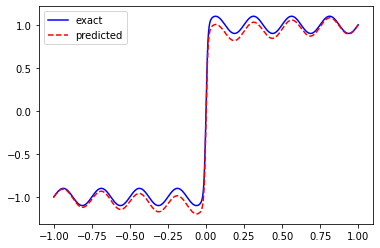

In [10]:
import matplotlib.pyplot as plt
plt.plot(data[:,0], data[:,2], 'b-', label = 'exact')
plt.plot(data[:,0], data[:,1], 'r--', label = 'predicted')
plt.legend()

In [11]:
##################################################################
# Recursive generation of the Jacobi polynomial of order n
def Jacobi(n,a,b,x):
    x=np.array(x)
    return (jacobi(n,a,b)(x))
    
##################################################################
# Derivative of the Jacobi polynomials
def DJacobi(n,a,b,x,k: int):
    x=np.array(x)
    ctemp = gamma(a+b+n+1+k)/(2**k)/gamma(a+b+n+1)
    return (ctemp*Jacobi(n-k,a+k,b+k,x))

    
##################################################################
# Weight coefficients
def GaussJacobiWeights(Q: int,a,b):
    [X , W] = roots_jacobi(Q,a,b)
    return [X, W]

##################################################################
# Weight coefficients
def GaussLobattoJacobiWeights(Q: int,a,b):
    W = []
    X = roots_jacobi(Q-2,a+1,b+1)[0]
    if a == 0 and b==0:
        W = 2/( (Q-1)*(Q)*(Jacobi(Q-1,0,0,X)**2) )
        Wl = 2/( (Q-1)*(Q)*(Jacobi(Q-1,0,0,-1)**2) )
        Wr = 2/( (Q-1)*(Q)*(Jacobi(Q-1,0,0,1)**2) )
    else:
        W = 2**(a+b+1)*gamma(a+Q)*gamma(b+Q)/( (Q-1)*gamma(Q)*gamma(a+b+Q+1)*(Jacobi(Q-1,a,b,X)**2) )
        Wl = (b+1)*2**(a+b+1)*gamma(a+Q)*gamma(b+Q)/( (Q-1)*gamma(Q)*gamma(a+b+Q+1)*(Jacobi(Q-1,a,b,-1)**2) )
        Wr = (a+1)*2**(a+b+1)*gamma(a+Q)*gamma(b+Q)/( (Q-1)*gamma(Q)*gamma(a+b+Q+1)*(Jacobi(Q-1,a,b,1)**2) )
    W = np.append(W , Wr)
    W = np.append(Wl , W)
    X = np.append(X , 1)
    X = np.append(-1 , X)    
    return [X, W]
##################################################################

Opt_Niter = 1000 + 1
Opt_tresh = 2e-32
var_form  = 1
N_Element = 1
Net_layer = [1] + [20] * 4 + [1] 
N_testfcn = 60
N_Quad = 80
N_F = 500  
lossb_weight = 1
    
#++++++++++++++++++++++++++++    
def Test_fcn(n,x):
    test  = Jacobi(n+1,0,0,x) - Jacobi(n-1,0,0,x)
    return test

#++++++++++++++++++++++++++++    
omega = 8*np.pi
amp = 1
r1 = 80
def u_ext(x):
    utemp = 0.1*np.sin(omega*x) + np.tanh(r1*x)
    return amp*utemp

def f_ext(x):
    gtemp =  -0.1*(omega**2)*np.sin(omega*x) - (2*r1**2)*(np.tanh(r1*x))/((np.cosh(r1*x))**2)
    return -amp*gtemp

#++++++++++++++++++++++++++++
NQ_u = N_Quad
[x_quad, w_quad] = GaussLobattoJacobiWeights(NQ_u, 0, 0)
testfcn = np.asarray([ Test_fcn(n,x_quad)  for n in range(1, N_testfcn+1)])

NE = N_Element
[x_l, x_r] = [-1, 1]
delta_x = (x_r - x_l)/NE
grid = np.asarray([ x_l + i*delta_x for i in range(NE+1)])
N_testfcn_total = np.array((len(grid)-1)*[N_testfcn])

if N_Element == 3:
    grid = np.array([-1, -0.1, 0.1, 1])
    NE = len(grid)-1
    N_testfcn_total = np.array([N_testfcn,N_testfcn,N_testfcn])

U_ext_total = []
F_ext_total = []
for e in range(NE):
    x_quad_element = grid[e] + (grid[e+1]-grid[e])/2*(x_quad+1)
    jacobian = (grid[e+1]-grid[e])/2
    N_testfcn_temp = N_testfcn_total[e]
    testfcn_element = np.asarray([ Test_fcn(n,x_quad)  for n in range(1, N_testfcn_temp+1)])

    u_quad_element = u_ext(x_quad_element)
    U_ext_element  = jacobian*np.asarray([sum(w_quad*u_quad_element*testfcn_element[i]) for i in range(N_testfcn_temp)])
    U_ext_element = U_ext_element[:,None]
    U_ext_total.append(U_ext_element)

    f_quad_element = f_ext(x_quad_element)
    F_ext_element  = jacobian*np.asarray([sum(w_quad*f_quad_element*testfcn_element[i]) for i in range(N_testfcn_temp)])
    F_ext_element = F_ext_element[:,None]
    F_ext_total.append(F_ext_element)

U_ext_total = np.asarray(U_ext_total)
F_ext_total = np.asarray(F_ext_total)

#++++++++++++++++++++++++++++
# Training points
X_u_train = np.asarray([-1.0,1.0])[:,None]
u_train   = u_ext(X_u_train)
X_bound = np.asarray([-1.0,1.0])[:,None]

Nf = N_F
X_f_train = (2*lhs(1,Nf)-1)
f_train   = f_ext(X_f_train)

#++++++++++++++++++++++++++++
# Quadrature points
[x_quad, w_quad] = GaussLobattoJacobiWeights(N_Quad, 0, 0)

X_quad_train = x_quad[:,None]
W_quad_train = w_quad[:,None]

#++++++++++++++++++++++++++++
# Test point
delta_test = 0.001
xtest      = np.arange(-1 , 1 + delta_test , delta_test)
data_temp  = np.asarray([ [xtest[i],u_ext(xtest[i])] for i in range(len(xtest))])
X_test = data_temp.flatten()[0::2]
u_test = data_temp.flatten()[1::2]
X_test = X_test[:,None]
u_test = u_test[:,None]
f_test = f_ext(X_test)

u_test_total = []
for e in range(NE):
    x_test_element = grid[e] + (grid[e+1]-grid[e])/2*(xtest+1)
    u_test_element = u_ext(x_test_element)
    u_test_element = u_test_element[:,None]
    u_test_total.append(u_test_element)

In [12]:
##################################################################
# Recursive generation of the Jacobi polynomial of order n
def Jacobi(n,a,b,x):
    x=np.array(x)
    return (jacobi(n,a,b)(x))
    
##################################################################
# Derivative of the Jacobi polynomials
def DJacobi(n,a,b,x,k: int):
    x=np.array(x)
    ctemp = gamma(a+b+n+1+k)/(2**k)/gamma(a+b+n+1)
    return (ctemp*Jacobi(n-k,a+k,b+k,x))

    
##################################################################
# Weight coefficients
def GaussJacobiWeights(Q: int,a,b):
    [X , W] = roots_jacobi(Q,a,b)
    return [X, W]

##################################################################
# Weight coefficients
def GaussLobattoJacobiWeights(Q: int,a,b):
    W = []
    X = roots_jacobi(Q-2,a+1,b+1)[0]
    if a == 0 and b==0:
        W = 2/( (Q-1)*(Q)*(Jacobi(Q-1,0,0,X)**2) )
        Wl = 2/( (Q-1)*(Q)*(Jacobi(Q-1,0,0,-1)**2) )
        Wr = 2/( (Q-1)*(Q)*(Jacobi(Q-1,0,0,1)**2) )
    else:
        W = 2**(a+b+1)*gamma(a+Q)*gamma(b+Q)/( (Q-1)*gamma(Q)*gamma(a+b+Q+1)*(Jacobi(Q-1,a,b,X)**2) )
        Wl = (b+1)*2**(a+b+1)*gamma(a+Q)*gamma(b+Q)/( (Q-1)*gamma(Q)*gamma(a+b+Q+1)*(Jacobi(Q-1,a,b,-1)**2) )
        Wr = (a+1)*2**(a+b+1)*gamma(a+Q)*gamma(b+Q)/( (Q-1)*gamma(Q)*gamma(a+b+Q+1)*(Jacobi(Q-1,a,b,1)**2) )
    W = np.append(W , Wr)
    W = np.append(Wl , W)
    X = np.append(X , 1)
    X = np.append(-1 , X)    
    return [X, W]
##################################################################

Opt_Niter = 1000 + 1
Opt_tresh = 2e-32
var_form  = 1
N_Element = 1
Net_layer = [1] + [20] * 4 + [1] 
N_testfcn = 60
N_Quad = 80
N_F = 500  
lossb_weight = 1
    
#++++++++++++++++++++++++++++    
def Test_fcn(n,x):
    test  = Jacobi(n+1,0,0,x) - Jacobi(n-1,0,0,x)
    return test

#++++++++++++++++++++++++++++    
omega = 8*np.pi
amp = 1
r1 = 80
def u_ext(x):
    utemp = 0.1*np.sin(omega*x) + np.tanh(r1*x)
    return amp*utemp

def f_ext(x):
    gtemp =  -0.1*(omega**2)*np.sin(omega*x) - (2*r1**2)*(np.tanh(r1*x))/((np.cosh(r1*x))**2)
    return -amp*gtemp

#++++++++++++++++++++++++++++
NQ_u = N_Quad
[x_quad, w_quad] = GaussLobattoJacobiWeights(NQ_u, 0, 0)
testfcn = np.asarray([ Test_fcn(n,x_quad)  for n in range(1, N_testfcn+1)])

NE = N_Element
[x_l, x_r] = [-1, 1]
delta_x = (x_r - x_l)/NE
grid = np.asarray([ x_l + i*delta_x for i in range(NE+1)])
N_testfcn_total = np.array((len(grid)-1)*[N_testfcn])

if N_Element == 3:
    grid = np.array([-1, -0.1, 0.1, 1])
    NE = len(grid)-1
    N_testfcn_total = np.array([N_testfcn,N_testfcn,N_testfcn])

U_ext_total = []
F_ext_total = []
for e in range(NE):
    x_quad_element = grid[e] + (grid[e+1]-grid[e])/2*(x_quad+1)
    jacobian = (grid[e+1]-grid[e])/2
    N_testfcn_temp = N_testfcn_total[e]
    testfcn_element = np.asarray([ Test_fcn(n,x_quad)  for n in range(1, N_testfcn_temp+1)])

    u_quad_element = u_ext(x_quad_element)
    U_ext_element  = jacobian*np.asarray([sum(w_quad*u_quad_element*testfcn_element[i]) for i in range(N_testfcn_temp)])
    U_ext_element = U_ext_element[:,None]
    U_ext_total.append(U_ext_element)

    f_quad_element = f_ext(x_quad_element)
    F_ext_element  = jacobian*np.asarray([sum(w_quad*f_quad_element*testfcn_element[i]) for i in range(N_testfcn_temp)])
    F_ext_element = F_ext_element[:,None]
    F_ext_total.append(F_ext_element)

U_ext_total = np.asarray(U_ext_total)
F_ext_total = np.asarray(F_ext_total)

#++++++++++++++++++++++++++++
# Training points
X_u_train = np.asarray([-1.0,1.0])[:,None]
u_train   = u_ext(X_u_train)
X_bound = np.asarray([-1.0,1.0])[:,None]

Nf = N_F
X_f_train = (2*lhs(1,Nf)-1)
f_train   = f_ext(X_f_train)

#++++++++++++++++++++++++++++
# Quadrature points
[x_quad, w_quad] = GaussLobattoJacobiWeights(N_Quad, 0, 0)

X_quad_train = x_quad[:,None]
W_quad_train = w_quad[:,None]

#++++++++++++++++++++++++++++
# Test point
delta_test = 0.001
xtest      = np.arange(-1 , 1 + delta_test , delta_test)
data_temp  = np.asarray([ [xtest[i],u_ext(xtest[i])] for i in range(len(xtest))])
X_test = data_temp.flatten()[0::2]
u_test = data_temp.flatten()[1::2]
X_test = X_test[:,None]
u_test = u_test[:,None]
f_test = f_ext(X_test)

u_test_total = []
for e in range(NE):
    x_test_element = grid[e] + (grid[e+1]-grid[e])/2*(xtest+1)
    u_test_element = u_ext(x_test_element)
    u_test_element = u_test_element[:,None]
    u_test_total.append(u_test_element)

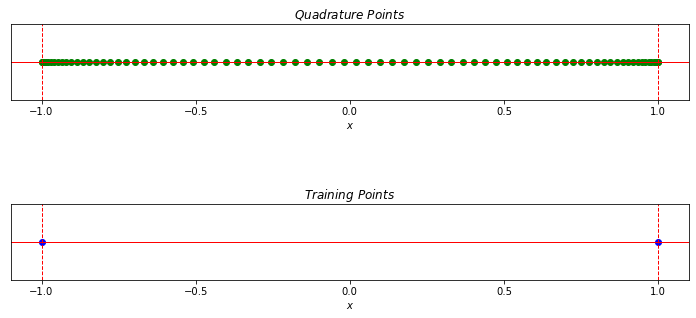

In [14]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
x_quad_plot = X_quad_train
y_quad_plot = np.empty(len(x_quad_plot))
y_quad_plot.fill(1)

x_train_plot = X_u_train
y_train_plot = np.empty(len(x_train_plot))
y_train_plot.fill(1) 

x_f_plot = X_f_train
y_f_plot = np.empty(len(x_f_plot))
y_f_plot.fill(1)

fig = plt.figure(0)
gridspec.GridSpec(3,1)

plt.subplot2grid((3,1), (0,0))
plt.tight_layout()
plt.locator_params(axis='x', nbins=6)
plt.yticks([])
plt.title('$Quadrature \,\, Points$')
plt.xlabel('$x$')
plt.axhline(1, linewidth=1, linestyle='-', color='red')
plt.axvline(-1, linewidth=1, linestyle='--', color='red')
plt.axvline(1, linewidth=1, linestyle='--', color='red')
plt.scatter(x_quad_plot,y_quad_plot, color='green')

plt.subplot2grid((3,1), (1,0))
plt.tight_layout()
plt.locator_params(axis='x', nbins=6)
plt.yticks([])
plt.title('$Training \,\, Points$')
plt.xlabel('$x$')
plt.axhline(1, linewidth=1, linestyle='-', color='red')
plt.axvline(-1, linewidth=1, linestyle='--', color='red')
plt.axvline(1, linewidth=1, linestyle='--', color='red')
plt.scatter(x_train_plot,y_train_plot, color='blue')

fig.tight_layout()
fig.set_size_inches(w=10,h=7)
plt.savefig('MyResults/vf1N3/Train-Quad-pnts.pdf')    

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
X_test = data[:,0]
u_pred = data[:,1]

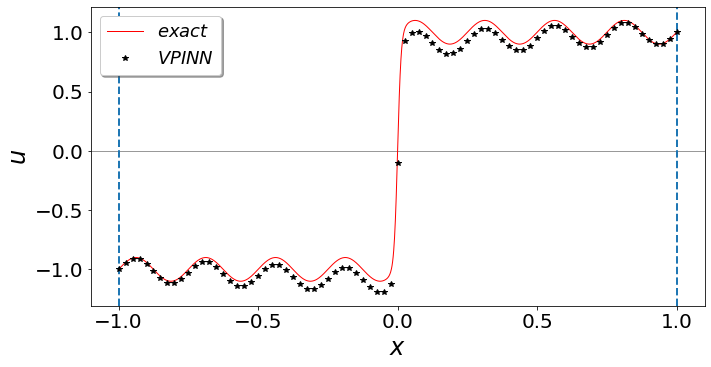

In [16]:
pnt_skip = 25
font = 24
fig, ax = plt.subplots()
plt.locator_params(axis='x', nbins=6)
plt.locator_params(axis='y', nbins=8)
plt.xlabel('$x$', fontsize = font)
plt.ylabel('$u$', fontsize = font)
plt.axhline(0, linewidth=0.8, linestyle='-', color='gray')
for xc in grid:
    plt.axvline(x=xc, linewidth=2, ls = '--')
plt.plot(X_test, u_test, linewidth=1, color='r', label=''.join(['$exact$']))
plt.plot(X_test[0::pnt_skip], u_pred[0::pnt_skip], 'k*', label='$VPINN$')
plt.tick_params( labelsize = 20)
legend = plt.legend(shadow=True, loc='upper left', fontsize=18, ncol = 1)
fig.set_size_inches(w=11,h=5.5)
plt.savefig('MyResults/vf1N3/prediction.pdf')

NameError: name 'loss_all_log' is not defined

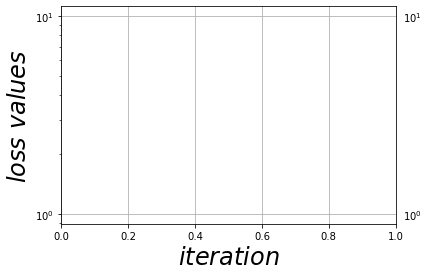

In [16]:

fig, ax = plt.subplots()
plt.tick_params(axis='y', which='both', labelleft='on', labelright='off')
plt.xlabel('$iteration$', fontsize = font)
plt.ylabel('$loss \,\, values$', fontsize = font)
plt.yscale('log')
plt.grid(True)
iteration = [i for i in range(len(loss_all_log))]
loss_his  = [loss_all_log[i].item() for i in range(len(loss_all_log))]
plt.plot(iteration, loss_his, 'gray')
plt.tick_params( labelsize = 20)
fig.set_size_inches(w=11,h=5.5)
plt.savefig('MyResults/loss.pdf')

C:\Users\Administrator\AppData\Local\Temp\ipykernel_22284\1940589969.py:10: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.axvline(x=xc, linewidth=2, ls = '--')


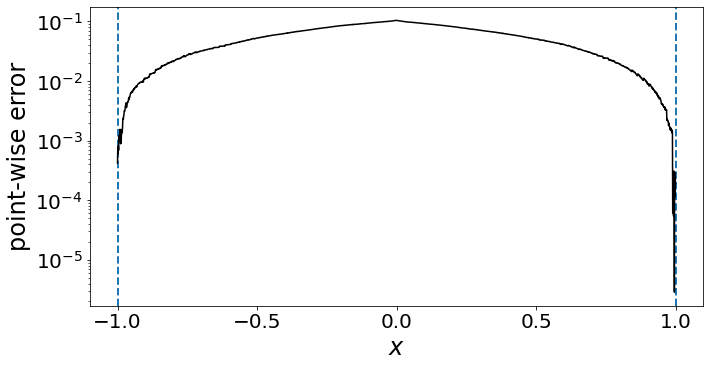

In [17]:
u_test = data[:,2]
fig, ax = plt.subplots()
plt.locator_params(axis='x', nbins=6)
plt.locator_params(axis='y', nbins=8)
plt.xlabel('$x$', fontsize = font)
plt.ylabel('point-wise error', fontsize = font)
plt.yscale('log')
plt.axhline(0, linewidth=0.8, linestyle='-', color='gray')
for xc in grid:
    plt.axvline(x=xc, linewidth=2, ls = '--')
plt.plot(X_test, abs(u_test - u_pred), 'k')
plt.tick_params( labelsize = 20)
fig.set_size_inches(w=11,h=5.5)
plt.savefig('MyResults/vf1N3/error.pdf')